This notebook uses the thickness prescription along the flow lines for the Aletsch glacier

In [1]:
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import climate, massbalance, flowline
from oggm.shop import gcm_climate, bedtopo

import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import os 

# oggm initialzation
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['use_multiprocessing']=True
cfg.PATHS['working_dir'] = '/home/lucillegimenes/oggm-workflow-b/'
cfg.PARAMS['continue_on_error'] = True
#cfg.PARAMS['run_mb_calibration'] = True

rgi_ids = ['RGI60-11.01450'] 
gdirs = workflow.init_glacier_directories(rgi_ids,from_prepro_level=2,prepro_rgi_version=62,prepro_border=80)
gdir=gdirs[0]

2021-11-02 11:05:23: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-11-02 11:05:23: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-11-02 11:05:23: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-11-02 11:05:23: oggm.cfg: Multiprocessing switched ON after user settings.
2021-11-02 11:05:23: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2021-11-02 11:05:23: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2021-11-02 11:05:23: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers


## Pre-processing tasks

In [2]:
prepro_task_list = [
        tasks.glacier_masks,  
        tasks.compute_centerlines,
        tasks.initialize_flowlines,
        tasks.compute_downstream_line,
        tasks.compute_downstream_bedshape,
        tasks.catchment_area,
        tasks.catchment_intersections,
        tasks.catchment_width_geom,
        tasks.catchment_width_correction   
        ]
for task in prepro_task_list:
    workflow.execute_entity_task(task, gdir)

2021-11-02 11:17:09: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2021-11-02 11:17:09: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2021-11-02 11:17:09: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2021-11-02 11:17:09: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2021-11-02 11:17:10: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2021-11-02 11:17:10: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2021-11-02 11:17:11: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
2021-11-02 11:17:11: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2021-11-02 11:17:13: oggm.workflow: Execute entity task catchment_width_correction on 1 glaciers


In [3]:
#climate tasks 
tasks.process_climate_data(gdir)
params_url = 'https://cluster.klima.uni-bremen.de/~oggm/ref_mb_params/oggm_v1.4/RGIV62/CRU/centerlines/qc3/pcp2.5'
workflow.download_ref_tstars(base_url=params_url)

climate_task_list = [
        tasks.local_t_star,     
        tasks.mu_star_calibration
        ]

for task in climate_task_list:
        workflow.execute_entity_task(task, gdir)

2021-11-02 11:17:28: oggm.workflow: Execute entity task local_t_star on 1 glaciers
2021-11-02 11:17:28: oggm.workflow: Execute entity task mu_star_calibration on 1 glaciers


In [6]:
#download and process gcm data
#precipitations
bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
#temperatures
bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'


2021-11-02 11:26:27: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.01450/outflow.shp ...
2021-11-02 11:26:27: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

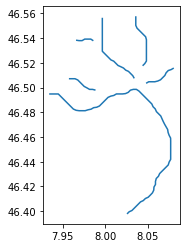

In [4]:
#converting flowlines to shapefile in the Aletsch directory
import write_to_shape 
#converting flowlines to shapefile 
path_to_shp='/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-'+gdir.rgi_region+'/'+gdir.rgi_id[0:11]+'/'+gdir.rgi_id+'/outflow.shp'
write_to_shape.write_centerlines_to_shape_bis(gdir, path=path_to_shp,flowlines_output=True)
""" write_to_shape_bis is the same function as utils.write_centerlines_to_shape, except that in
the first one, the flowlines are ranked (or classified ?) according to their segment id"""
sh = gpd.read_file(path_to_shp)
sh.plot()

## Prescription of the thicknesses

### Extraction of the thicknesses

Because of a package compability problem with OGGM (with gdal), the next step needs to be done in an other environnement 

In [ ]:
#The following lines are executed outisde the OGGM environnment 
"""import extraction_dev_2
extraction_dev_2.extract_thickness([gdir.rgi_id],'farinotti')
extraction_dev_2.extract_thickness([gdir.rgi_id],'millan')"""
# the function extraction_dev_2 take the flowlines from the shapefile created previously, finds the corresponding
# thicknesses in the millan or farinotti file, and puts them in a pickle file in the Aletsch directory


### A few ajustments

In [7]:
cfg.add_to_basenames('model_geometry_my_spinup','model_geometry_my_spinup.nc')
cfg.add_to_basenames('model_geometry_with_spinup','model_geometry_with_spinup.nc')

In [8]:
gdir.name_corr=gdir.name.replace('/','-')
if (gdir.name==''):
    gdir.name_corr='Aletsch'

### Prescription of thicknesses


The following function prescribes the thicknesses according to the chosen data source

In [26]:
import logging
import warnings
import pickle


# Module logger
log = logging.getLogger(__name__)

import numpy as np
from scipy.interpolate import griddata
from scipy import optimize

from oggm import cfg, utils, workflow, tasks, graphics, core
from oggm.core.inversion import _vol_below_water 

def ice_thickness_from_data(gdir, glen_a=None, fs=None, write=True,
                                filesuffix='', water_level=None,
                                t_lambda=None,data_file=''):
    """ Download from data the glacier thickness along the flowlines
    
    Parameters
    ----------
    gdir : :py:class:`oggm.GlacierDirectory`
        the glacier directory to process
    glen_a : float
        glen's creep parameter A. Defaults to cfg.PARAMS.
    fs : float
        sliding parameter. Defaults to cfg.PARAMS.
    write: bool
        default behavior is to compute the thickness and write the
        results in the pickle. Set to False in order to spare time
        during calibration.
    filesuffix : str
        add a suffix to the output file
    water_level : float
        to compute volume below water level - adds an entry to the output dict
    t_lambda : float
        defining the angle of the trapezoid walls (see documentation). Defaults
        to cfg.PARAMS.
    data_file : the file containing the thicknesses along the flowlines
    """

    # Defaults
    if glen_a is None:
        glen_a = cfg.PARAMS['inversion_glen_a']
    if fs is None:
        fs = cfg.PARAMS['inversion_fs']
    if t_lambda is None:
        t_lambda = cfg.PARAMS['trapezoid_lambdas']


    # Ice flow params
    fd = 2. / (cfg.PARAMS['glen_n']+2) * glen_a
    a3 = fs / fd
    rho = cfg.PARAMS['ice_density']

    # Inversion with shape factors?
    sf_func = None
    use_sf = cfg.PARAMS.get('use_shape_factor_for_inversion', None)
    if use_sf == 'Adhikari' or use_sf == 'Nye':
        sf_func = utils.shape_factor_adhikari
    elif use_sf == 'Huss':
        sf_func = utils.shape_factor_huss

    # Clip the slope, in rad
    min_slope = 'min_slope_ice_caps' if gdir.is_icecap else 'min_slope'
    min_slope = np.deg2rad(cfg.PARAMS[min_slope])

    out_volume = 0.

    cls = gdir.read_pickle('inversion_input')
    
    with open(data_file, 'rb') as db_file:
        thick_data = pickle.load(db_file)

    k=-1 #future loop index for thick_data
    for cl in cls:
        k+=1
        
        # Clip slope to avoid negative and small slopes
        slope = cl['slope_angle']
        slope = utils.clip_array(slope, min_slope, np.pi/2.)

        # Glacier width
        w = cl['width']
        a0s = - cl['flux_a0'] / ((rho*cfg.G*slope)**3*fd)
        sf = np.ones(slope.shape)  # Default shape factor is 1

        #Glacier thickness
                #Glacier thickness
        #temporaire (supprimez dernier élément si un en trop)
        while (len(thick_data[k])!=len(cl['width'])):
            thick_data[k]=np.delete(thick_data[k],len(thick_data[k])-1)
        
        out_thick = thick_data[k]

        # volume
        is_rect = cl['is_rectangular']
        fac = np.where(is_rect, 1, 2./3.)
        volume = fac * out_thick * w * cl['dx']

        # Now recompute thickness where parabola is too flat
        is_trap = cl['is_trapezoid']
        if cl['invert_with_trapezoid']:
            min_shape = cfg.PARAMS['mixed_min_shape']
            bed_shape = 4 * out_thick / w ** 2
            is_trap = ((bed_shape < min_shape) & ~ cl['is_rectangular'] & (cl['flux'] > 0)) | is_trap
            for i in np.where(is_trap)[0]:
                try:
                    out_thick[i] = thick_data[k][i]
                    sect = (2*w[i] - t_lambda * out_thick[i]) / 2 * out_thick[i]
                    volume[i] = sect * cl['dx']
                except ValueError:
                    # no solution error - we do with rect
                    out_thick[i] = thick_data[k][i]
                    is_rect[i] = True
                    is_trap[i] = False
                    volume[i] = out_thick[i] * w[i] * cl['dx']

        # Sanity check
        if np.any(out_thick <= 0):
            log.warning("Found zero or negative thickness: "
                        "this should not happen.")

        if write:
            cl['is_trapezoid'] = is_trap
            cl['is_rectangular'] = is_rect
            cl['thick'] = out_thick
            cl['volume'] = volume

            # volume below sl
            try:
                bed_h = cl['hgt'] - out_thick
                bed_shape = 4 * out_thick / w ** 2
                if np.any(bed_h < 0):
                    cl['volume_bsl'] = _vol_below_water(cl['hgt'], bed_h,
                                                        bed_shape, out_thick,
                                                        w,
                                                        cl['is_rectangular'],
                                                        cl['is_trapezoid'],
                                                        fac, t_lambda,
                                                        cl['dx'], 0)
                if water_level is not None and np.any(bed_h < water_level):
                    cl['volume_bwl'] = _vol_below_water(cl['hgt'], bed_h,
                                                        bed_shape, out_thick,
                                                        w,
                                                        cl['is_rectangular'],
                                                        cl['is_trapezoid'],
                                                        fac, t_lambda,
                                                        cl['dx'],
                                                        water_level)
            except KeyError:
                # cl['hgt'] is not available on old prepro dirs
                pass

        out_volume += np.sum(volume)

    if write:
        gdir.write_pickle(cls, 'inversion_output', filesuffix=filesuffix)
        gdir.add_to_diagnostics('inversion_glen_a', glen_a)
        gdir.add_to_diagnostics('inversion_fs', fs)

    return out_volume


### Loop on the data sources

This loop will computes the initial state of the glacier, according to the data sources : OGGM, Farinotti or Millan. For the two last two, the thickness is prescribed via the ice_thickness_from_data function

2021-11-02 14:27:56: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-11-02 14:27:56: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2021-11-02 14:27:56: oggm.workflow: Execute entity task distribute_thickness_per_altitude on 1 glaciers


oggm


2021-11-02 14:27:59: oggm.workflow: Execute entity task init_present_time_glacier on 1 glaciers
2021-11-02 14:27:59: oggm.workflow: Execute entity task run_constant_climate on 1 glaciers
2021-11-02 14:28:39: oggm.workflow: Execute entity task run_with_hydro on 1 glaciers
2021-11-02 14:28:46: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-11-02 14:28:46: __main__: Found zero or negative thickness: this should not happen.
2021-11-02 14:28:46: oggm.workflow: Execute entity task distribute_thickness_per_altitude on 1 glaciers


farinotti
Extraction OK


2021-11-02 14:28:50: oggm.workflow: Execute entity task add_consensus_thickness on 1 glaciers
/tmp/ipykernel_57049/4147530063.py:149: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  propf=prop.astype(np.float)
/tmp/ipykernel_57049/4147530063.py:173: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  propf=prop.astype(np.float)
/tmp/ipykernel_570

millan
Extraction OK


/tmp/ipykernel_57049/4147530063.py:149: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  propf=prop.astype(np.float)
/tmp/ipykernel_57049/4147530063.py:173: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  propf=prop.astype(np.float)
/tmp/ipykernel_57049/4147530063.py:204: DeprecationWarning: `np.float` is a deprecated alias for the builtin `fl

Duration is
--- 234.49119544029236 seconds ---


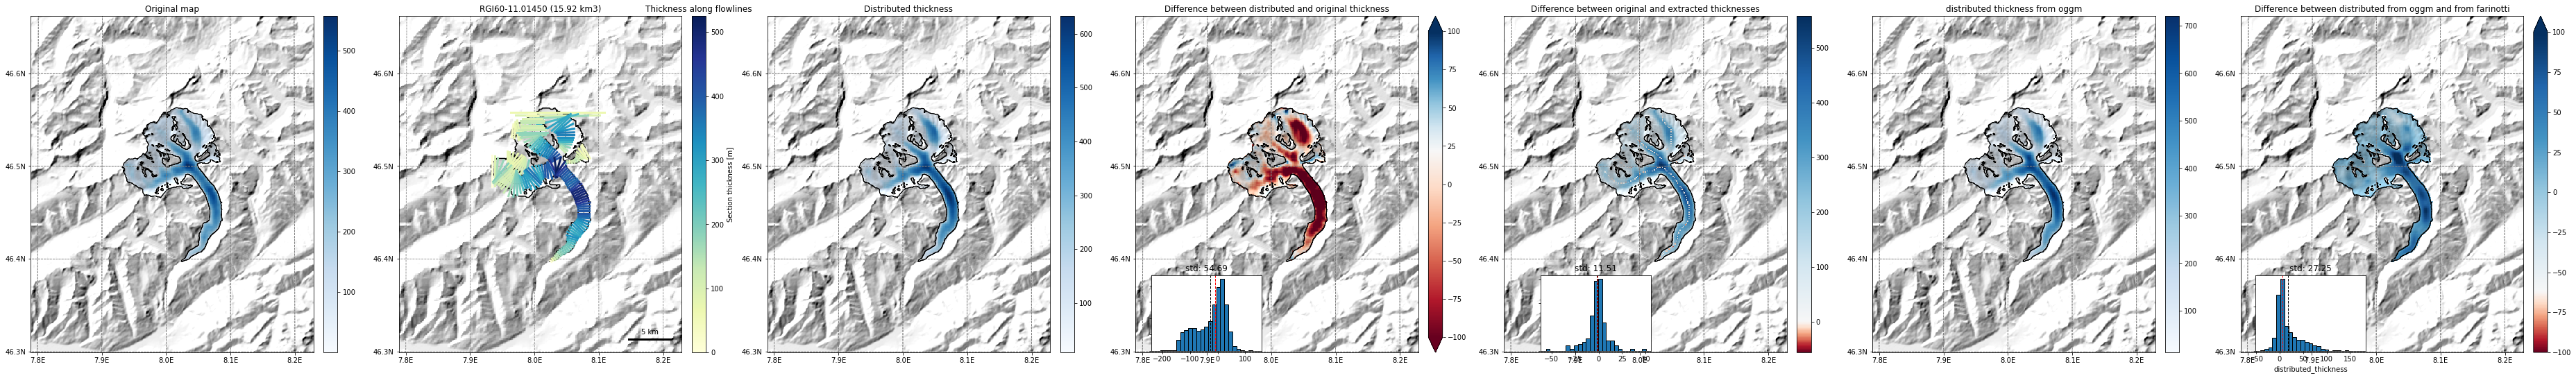

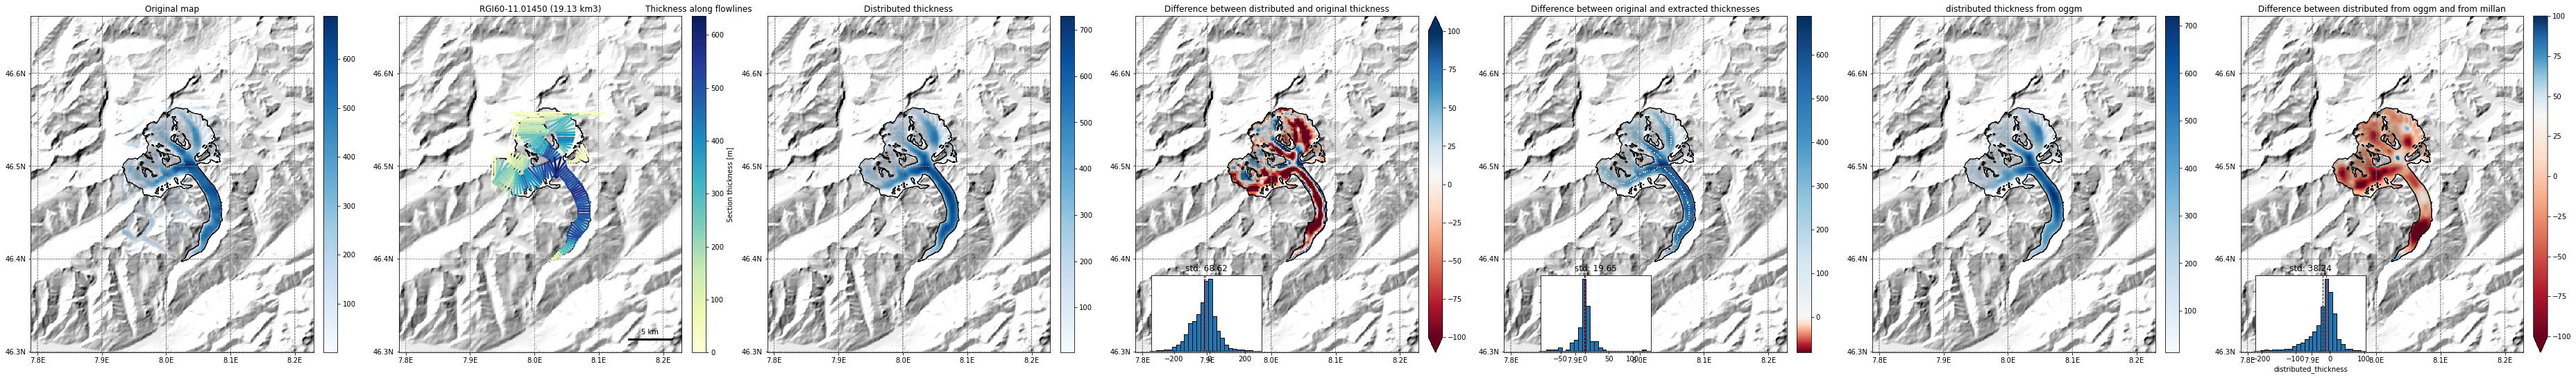

In [29]:
import pickle
import thickness_init
import add_data
import graph
import matplotlib
import statistics as stc
from matplotlib import cm as colormap
from oggm.workflow import execute_entity_task
import imageio
from __future__ import division
from scipy import *                 
from pylab import *
import os
import logging
import warnings


# Module logger
log = logging.getLogger(__name__)

import numpy as np
from scipy.interpolate import griddata
from scipy import optimize

from oggm import cfg, utils, workflow, tasks, graphics, core
from oggm.core.inversion import _vol_below_water 

import time

# start time !
start_time = time.time()

list_out_surf=[0]*3 #pre allocate for later plotting profile 
list_out_bed=[0]*3


orig_cmap = matplotlib.cm.RdBu

#little adjustments for Millan files
if (gdir.rgi_region in ['13','14','15']):
    gdir.rgi_region_m='13-15'
else:
    gdir.rgi_region_m=gdir.rgi_region

    
data_list=['oggm','farinotti','millan']
k=0 
for data in data_list:
    print(data)
    ##### Initial thickness ######
    
    workflow.execute_entity_task(tasks.prepare_for_inversion, gdir)
    
    if (data=='millan') or (data=='farinotti'):
        
        #checking if we have the right number of points on the flowlines
        cls=gdir.read_pickle('inversion_input')
        path_to_pkl='/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-'+gdir.rgi_region+'/'+gdir.rgi_id[0:11]+'/'+gdir.rgi_id+'/db_'+data+'.pkl'
        with open(path_to_pkl, 'rb') as db_file:
            data_test = pickle.load(db_file)

        ind=0
        for i in range(0,len(data_test)):
            if (len(cls[i]['width'])!=len(data_test[i])):
                ind+=1
        if (ind==0):
            print('Extraction OK')
        else:
            print('Problème extraction')
        
        #creating 'inversion_output.pkl'
        #This is where the proper prescription of the thicknesses happend (with the function ice_thickness_from_data)
        path_to_pkl='/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-'+gdir.rgi_region+'/'+gdir.rgi_id[0:11]+'/'+gdir.rgi_id+'/db_'+data+'.pkl'
        ice_thickness_from_data(gdir,data_file=path_to_pkl)

    else:
        # if we don't use thicknesses from millan or farinotti, we use the one calculated by OGGM
        workflow.execute_entity_task(tasks.mass_conservation_inversion,gdir)

    #workflow.execute_entity_task(tasks.filter_inversion_output,gdir)
    
    #for later (max of colorbar)
    max_thick=0
    cls=gdir.read_pickle('inversion_output')
    for m in range(0,len(cls)):
        if (max(cls[m]['thick'])>max_thick):
            max_thick=max(cls[m]['thick'])


    
    #cosmetic task
    workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdir);

    if (data=='farinotti'):
        workflow.execute_entity_task(bedtopo.add_consensus_thickness, gdir);
        add_data.mapped_extracted_thickness(gdir)
    elif (data=='millan'):
        add_data.add_data_thickness(gdir,'/home/lucillegimenes/Bureau/THICKNESS_Millan/RGI-'+gdir.rgi_region_m+'/per_glacier/'+gdir.rgi_id+'_thickness_m_from_f.tif')
        add_data.mapped_extracted_thickness(gdir)
        
    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        ds = ds.load()
        
    if(data=='farinotti'):
        compare_data=ds.consensus_ice_thickness
    elif(data=='millan'):
        compare_data=ds.millan_thickness
    else:
        save_oggm=ds.distributed_thickness


    if (data=='farinotti') or (data=='millan'):
            
        f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7)= plt.subplots(1, 7, figsize=(65, 15))
        
        #Original map 
        smap = ds.salem.get_map(countries=False)
        smap.set_shapefile(gdir.read_shapefile('outlines'))
        smap.set_topography(ds.topo.data);
        smap.set_data(compare_data)
        smap.set_cmap('Blues')
        #smap.set_vmax(val=max_thick)
        smap.plot(ax=ax1)
        smap.visualize(ax=ax1,title='Original map')
        #smap.append_colorbar(ax=ax1, label='ice thickness (m)');
        
        #Thickness along flowline (widths)
        graphics.plot_inversion(gdir,ax=ax2)
        plt.title('Thickness along flowlines')
        
        
        #Thickness distributed after prescription from data source (farinotti or millan)
        smap3 = ds.salem.get_map(countries=False)
        smap3.set_shapefile(gdir.read_shapefile('outlines'))
        smap3.set_topography(ds.topo.data);
        smap3.set_data(ds.distributed_thickness)
        #smapf.set_vmax(val=max_thick)
        smap3.set_cmap('Blues')
        smap3.plot(ax=ax3)
        smap3.visualize(ax=ax3,title='Distributed thickness')

        
        #Difference btw thickness directly from source and the one after distribution 
        smap4 = ds.salem.get_map(countries=False)
        smap4.set_shapefile(gdir.read_shapefile('outlines'))
        smap4.set_topography(ds.topo.data);
        smap4.set_data(compare_data-ds.distributed_thickness)
        prop=abs(np.min(compare_data-ds.distributed_thickness))/(np.max(compare_data-ds.distributed_thickness)+abs(np.min(compare_data-ds.distributed_thickness)))
        propf=prop.astype(np.float)
        shifted_cmap = graph.shiftedColorMap(orig_cmap, midpoint=propf, name='shifted')
        smap4.set_cmap(shifted_cmap)
        smap4.set_vmax(val=100)
        smap4.set_vmin(val=-100)
        smap4.plot(ax=ax4)
        smap4.visualize(ax=ax4,title='Difference between distributed and original thickness')
        #smapp.append_colorbar(ax=ax4, label='ice thickness (m)');
        ax11 = f.add_axes([0.47, 0.28, 0.034, 0.101])
        ax11.set_yticklabels([])
        var=compare_data-ds.distributed_thickness
        var.plot.hist(bins=25,edgecolor='k',density=True)
        plt.axvline(var.mean(), color='k', linestyle='dashed', linewidth=1)
        plt.axvline(var.median(), color='r', linestyle='dashed', linewidth=1)
        std=float(var.std())
        plt.title('std: {:.2f}'.format(std))
        
        
        #Difference btw thickness directly from source and the one after extraction
        smap5 = ds.salem.get_map(countries=False)
        smap5.set_shapefile(gdir.read_shapefile('outlines'))
        smap5.set_topography(ds.topo.data);
        smap5.set_data(compare_data-ds.extracted_thickness)
        prop=abs(np.min(compare_data-ds.extracted_thickness))/(np.max(compare_data-ds.extracted_thickness)+abs(np.min(compare_data-ds.extracted_thickness)))
        propf=prop.astype(np.float)
        shifted_cmap2 = graph.shiftedColorMap(orig_cmap, midpoint=propf, name='shifted')
        smap5.set_cmap(shifted_cmap2)
        smap5.plot(ax=ax5)
        smap5.visualize(ax=ax5,title='Difference between original and extracted thicknesses')
        ax12 = f.add_axes([0.59, 0.28, 0.034, 0.101])
        ax12.set_yticklabels([])
        var=compare_data-ds.extracted_thickness_hist
        var.plot.hist(bins=25,edgecolor='k',density=True)
        plt.axvline(var.mean(), color='k', linestyle='dashed', linewidth=1)
        plt.axvline(var.median(), color='r', linestyle='dashed', linewidth=1)
        std=float(var.std())
        plt.title('std: {:.2f}'.format(std))
        

        #Distributed thickness only from oogm 
        smap6 = ds.salem.get_map(countries=False)
        smap6.set_shapefile(gdir.read_shapefile('outlines'))
        smap6.set_topography(ds.topo.data);
        smap6.set_data(save_oggm)
        smap6.set_cmap('Blues')
        #smapl.set_vmax(val=max_thick)
        smap6.plot(ax=ax6)
        smap6.visualize(ax=ax6,title='distributed thickness from oggm')
        
        #Difference between distributed from source and from oggm
        smap7 = ds.salem.get_map(countries=False)
        smap7.set_shapefile(gdir.read_shapefile('outlines'))
        smap7.set_topography(ds.topo.data);
        smap7.set_data(save_oggm-ds.distributed_thickness)
        prop=abs(np.min(save_oggm-ds.distributed_thickness))/(np.max(save_oggm-ds.distributed_thickness)+abs(np.min(save_oggm-ds.distributed_thickness)))
        propf=prop.astype(np.float)
        shifted_cmap = graph.shiftedColorMap(orig_cmap, midpoint=propf, name='shifted')
        smap7.set_cmap(shifted_cmap)
        smap7.set_vmax(val=100)
        smap7.set_vmin(val=-100)
        smap7.plot(ax=ax7)
        smap7.visualize(ax=ax7,title='Difference between distributed from oggm and from '+data+'')
        #smapp.append_colorbar(ax=ax4, label='ice thickness (m)');
        ax13 = f.add_axes([0.81, 0.28, 0.034, 0.101])
        ax13.set_yticklabels([])
        var=save_oggm-ds.distributed_thickness
        var.plot.hist(bins=25,edgecolor='k',density=True)
        plt.axvline(var.mean(), color='k', linestyle='dashed', linewidth=1)
        plt.axvline(var.median(), color='r', linestyle='dashed', linewidth=1)
        std=float(var.std())
        plt.title('std: {:.2f}'.format(std))
        
        name = ''+gdir.name_corr+'_'+data+'_panel.png'
        plt.savefig(name, format = 'png')
        

    ###### Spin-up ######    
    #initialization 
    workflow.execute_entity_task(tasks.init_present_time_glacier, gdir) 


    #Run the spinup simulation - t* climate    
    workflow.execute_entity_task(tasks.run_constant_climate, gdir,nyears=300,output_filesuffix='_my_spinup') 



    # Run a past climate run based on this spinup
    execute_entity_task(tasks.run_with_hydro, gdir, run_task=tasks.run_from_climate_data,
                                climate_filename='climate_historical',
                                ys=2003, ye=2020,init_model_filesuffix='_my_spinup',
                                output_filesuffix='_with_spinup',store_monthly_hydro=True)
            
           

        #For plotting a profile
    fmod = flowline.FileModel(gdir.get_filepath('model_geometry_with_spinup'))
    fl = fmod.fls[-1]  # Main flowline
    i, j = fl.line.xy  # xy flowline on grid
    lons, lats = gdir.grid.ij_to_crs(i, j, crs='EPSG:4326')  # to WGS84

    df_coords = pd.DataFrame(index=fl.dis_on_line*gdir.grid.dx)
    df_coords.index.name = 'Distance along flowline'
    df_coords['lon'] = lons
    df_coords['lat'] = lats
    df_coords['bed_elevation'] = fl.bed_h

    df_thick = pd.DataFrame(index=df_coords.index)
    df_surf_h = pd.DataFrame(index=df_coords.index)
    df_bed_h = pd.DataFrame()

    for year in range(2003, 2005):
        fmod.run_until(year)
        fl = fmod.fls[-1]
        df_thick[year] = fl.thick
        df_surf_h[year] = fl.surface_h

    list_out_surf[k]= df_surf_h[[2003]]
    list_out_bed[k]=df_coords['bed_elevation']


    k+=1
    

print('Duration is')
print("--- %s seconds ---" % (time.time() - start_time))

## Plotting the glacier profile

In [23]:
df_surf=pd.concat([list_out_surf[1],list_out_surf[2],list_out_surf[0]], axis=1)
df_bed=pd.concat([list_out_bed[1],list_out_bed[2],list_out_bed[0]], axis=1)

In [24]:
df_surf.columns=['farinotti','millan','oggm']
df_bed.columns=['bed farinotti','bed millan','bed oggm']

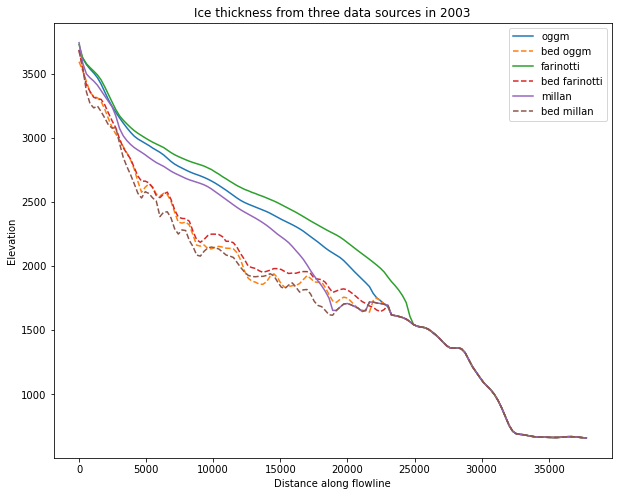

In [25]:
f, ax = plt.subplots(figsize=(10, 8))
for data in data_list:
    df_surf[[data]].plot(ax=ax);
    plt.legend()
    df_bed[['bed '+data+'']].plot(ax=ax,ylabel='Elevation',style="--");
    plt.legend()
plt.title('Ice thickness from three data sources in 2003');
name = ''+gdir.name_corr+'_profil_init.png'
plt.savefig(name, format = 'png')
